# **Download Library**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 
     |████████████████████████████████| 120 kB 67.8 MB/s 


# **Import Library**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import transformers
from transformers import BertTokenizer, BertConfig

# **Load Dataset**

In [ ]:
dwn_url='https://drive.google.com/uc?id=' + '1hA625b2EGrhetDlry7dEDDoZZ9PQQ9Zr'
df = pd.read_csv(dwn_url)
df

,title,text,subject,date,output
0,watch: these videos will make trump the most ...,john kasich becam last rival pull campaign ced...,news,"May 5, 2016",1
1,here’s what happens when children win a scien...,indiana school stage robot competit fourth gra...,news,"March 17, 2017",1
2,tx teacher infuriates mother with note implyi...,texa mother recent woke possibl one infuri thi...,news,"June 17, 2016",1
3,japan weighs plans to deal with north korean e...,tokyo reuter japan studi plan cope influx perh...,worldnews,"November 16, 2017",0
4,"""make republicans whole again!"" a divided part...",cleveland reuter ted cruz recount audienc outl...,politicsnews,"July 21, 2016",0
...,...,...,...,...,...
44158,trump halts travel in new executive order,st centuri wire say presid donald j trump prev...,middle-east,"March 6, 2017",1
44159,new u.s. u.n. envoy warns allies: back us or w...,unit nation reuter new us ambassador unit nati...,politicsnews,"January 27, 2017",0
44160,"greek police, protesters clash in athens durin...",athen reuter riot polic fire tearga tuesday pr...,politicsnews,"November 15, 2016",0
44161,brutal myanmar army operation aimed at prevent...,geneva reuter myansecur forc brutal driven hal...,worldnews,"October 11, 2017",0


In [ ]:
# drop kolom title, subject, date
df = df.drop(['title', 'subject', 'date'], axis=1)

In [ ]:
df

,text,output
0,john kasich becam last rival pull campaign ced...,1
1,indiana school stage robot competit fourth gra...,1
2,texa mother recent woke possibl one infuri thi...,1
3,tokyo reuter japan studi plan cope influx perh...,0
4,cleveland reuter ted cruz recount audienc outl...,0
...,...,...
44158,st centuri wire say presid donald j trump prev...,1
44159,unit nation reuter new us ambassador unit nati...,0
44160,athen reuter riot polic fire tearga tuesday pr...,0
44161,geneva reuter myansecur forc brutal driven hal...,0


# **Splitting Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)
y_train = train["output"].values
y_test = test["output"].values

# **Feature Engineering**

## Data Train

In [ ]:
corpus = train["text"]
maxlen = 50

## tambahkan special tokens
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## membuat masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
## membuat padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## membuat idx
idx = [tokenizer.convert_tokens_to_ids(seq.split(" ")) for seq in txt2seq]
    
## membuat segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## membuat fitur matrix
X_train = [np.asarray(idx, dtype='int32'),
           np.asarray(masks, dtype='int32'),
           np.asarray(segments, dtype='int32')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors


## Data Test

In [ ]:
corpus = test["text"]
maxlen = 50

## tambahkan special tokens
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## membuat masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
## membuat padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## membuat idx
idx = [tokenizer.convert_tokens_to_ids(seq.split(" ")) for seq in txt2seq]
    
## membuat segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## membuat fitur matrix
X_test = [np.asarray(idx, dtype='int32'),
          np.asarray(masks, dtype='int32'),
          np.asarray(segments, dtype='int32')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
Token indices sequence length is longer than the specified maximum sequence length for this model (872 > 512). Running this sequence through the model will result in indexing errors


# **Buat Model**

## GELU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="gelu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer

## RELU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="relu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model_1 = models.Model([idx, masks, segments], y_out)
for layer in model_1.layers[:4]:
    layer.trainable = False
model_1.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model_1.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLay

## SILU

In [ ]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
segments = layers.Input((50), dtype="int32", name="input_segments")
## config Bert
config = BertConfig(
            # vocab_size=30522,
            # hidden_size=768,
            # num_hidden_layers=12,
            # num_attention_heads=12,
            # intermediate_size=3072,
            hidden_act="silu"
            # hidden_dropout_prob=0.2,
            # attention_probs_dropout_prob=0.2
            # max_position_embeddings=512,
            # type_vocab_size=2,
            # initializer_range=0.02,
            # layer_norm_eps=1e-12,
            # pad_token_id=0,
            # position_embedding_type="absolute",
            # use_cache=True,
            # classifier_dropout=None
        )
## pre-trained bert
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased", config = config)
print(nlp.config)
bert_out = nlp([idx, masks, segments])[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model_2 = models.Model([idx, masks, segments], y_out)
for layer in model_2.layers[:4]:
    layer.trainable = False
model_2.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model_2.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "silu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer

# **Latih Model**

## GELU

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training = model.fit(x=X_train, y=y_train, 
                     batch_size=64, 
                     epochs=200, 
                     # steps_per_epoch=100,
                     shuffle=True, 
                     verbose=1, 
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 118s 309ms/step - loss: 0.2196 - accuracy: 0.9157 - val_loss: 0.0992 - val_accuracy: 0.9656
Epoch 2/200
339/339 [==============================] - 106s 314ms/step - loss: 0.1126 - accuracy: 0.9602 - val_loss: 0.0781 - val_accuracy: 0.9734
Epoch 3/200
339/339 [==============================] - 109s 321ms/step - loss: 0.0939 - accuracy: 0.9664 - val_loss: 0.0694 - val_accuracy: 0.9741
Epoch 4/200
339/339 [==============================] - 109s 321ms/step - loss: 0.0804 - accuracy: 0.9713 - val_loss: 0.0509 - val_accuracy: 0.9843
Epoch 5/200
339/339 [==============================] - 109s 321ms/step - loss: 0.0749 - accuracy: 0.9732 - val_loss: 0.0504 - val_accuracy: 0.9833
Epoch 6/200
339/339 [==============================] - 109s 321ms/step - loss: 0.0734 - accuracy: 0.9749 - val_loss: 0.0455 - val_accuracy: 0.9860
Epoch 7/200
339/339 [==============================] - 109s 321ms/step - loss: 0.0727 - accuracy: 0.9742 - val_loss: 0

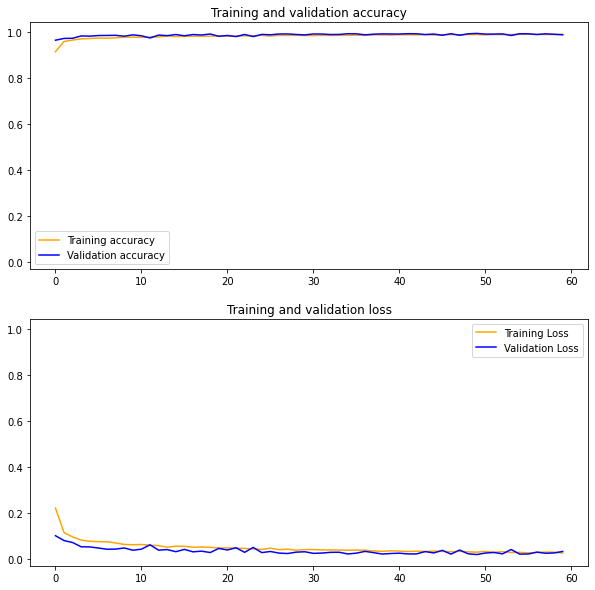

In [ ]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
model.save("model_1.h5")

## RELU

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training_1 = model_1.fit(x=X_train, y=y_train, 
                     batch_size=64, 
                     epochs=200, 
                     # steps_per_epoch=100,
                     shuffle=True, 
                     verbose=1, 
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 114s 303ms/step - loss: 0.5230 - accuracy: 0.7927 - val_loss: 0.3248 - val_accuracy: 0.9106
Epoch 2/200
339/339 [==============================] - 99s 292ms/step - loss: 0.2813 - accuracy: 0.9085 - val_loss: 0.1863 - val_accuracy: 0.9443
Epoch 3/200
339/339 [==============================] - 99s 291ms/step - loss: 0.2033 - accuracy: 0.9322 - val_loss: 0.1393 - val_accuracy: 0.9569
Epoch 4/200
339/339 [==============================] - 99s 291ms/step - loss: 0.1664 - accuracy: 0.9446 - val_loss: 0.1079 - val_accuracy: 0.9720
Epoch 5/200
339/339 [==============================] - 99s 291ms/step - loss: 0.1414 - accuracy: 0.9536 - val_loss: 0.0840 - val_accuracy: 0.9799
Epoch 6/200
339/339 [==============================] - 99s 292ms/step - loss: 0.1260 - accuracy: 0.9576 - val_loss: 0.0758 - val_accuracy: 0.9818
Epoch 7/200
339/339 [==============================] - 99s 291ms/step - loss: 0.1236 - accuracy: 0.9593 - val_loss: 0.0663 

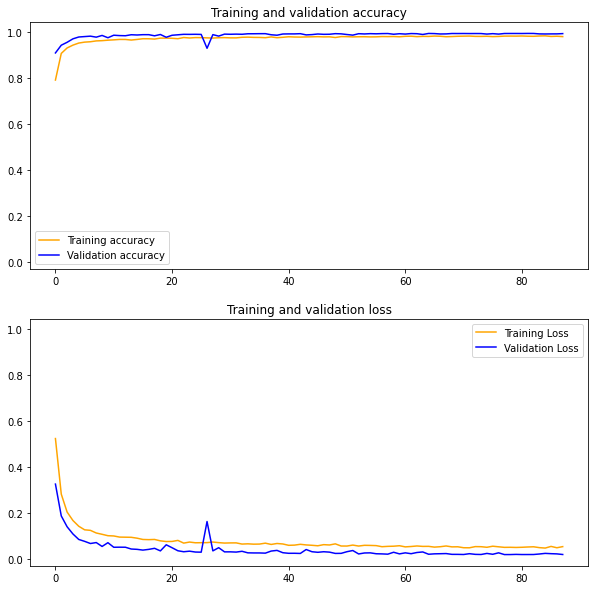

In [ ]:
acc = training_1.history['accuracy']
val_acc = training_1.history['val_accuracy']
loss = training_1.history['loss']
val_loss = training_1.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
model_1.save("model_2.h5")

## SILU

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## tambah early stopping: membuat model berhenti saat ingin overfitting ketika dilatih
early_stopping = EarlyStopping(patience=10)
## train
training_2 = model_2.fit(x=X_train, y=y_train, 
                     batch_size=64, 
                     epochs=200, 
                     # steps_per_epoch=100,
                     shuffle=True, 
                     verbose=1, 
                     callbacks=[early_stopping],
                     validation_split=0.3)
# ## test
# predicted_prob = model.predict(X_test)
# predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
#              predicted_prob]

Epoch 1/200
339/339 [==============================] - 112s 294ms/step - loss: 0.5553 - accuracy: 0.7097 - val_loss: 0.3828 - val_accuracy: 0.8429
Epoch 2/200
339/339 [==============================] - 102s 300ms/step - loss: 0.4958 - accuracy: 0.7583 - val_loss: 0.3425 - val_accuracy: 0.8701
Epoch 3/200
339/339 [==============================] - 103s 305ms/step - loss: 0.4826 - accuracy: 0.7675 - val_loss: 0.3167 - val_accuracy: 0.8725
Epoch 4/200
339/339 [==============================] - 103s 305ms/step - loss: 0.4698 - accuracy: 0.7772 - val_loss: 0.3238 - val_accuracy: 0.8653
Epoch 5/200
339/339 [==============================] - 103s 304ms/step - loss: 0.4624 - accuracy: 0.7807 - val_loss: 0.4248 - val_accuracy: 0.7961
Epoch 6/200
339/339 [==============================] - 103s 304ms/step - loss: 0.4597 - accuracy: 0.7816 - val_loss: 0.3040 - val_accuracy: 0.8754
Epoch 7/200
339/339 [==============================] - 103s 304ms/step - loss: 0.4585 - accuracy: 0.7793 - val_loss: 0

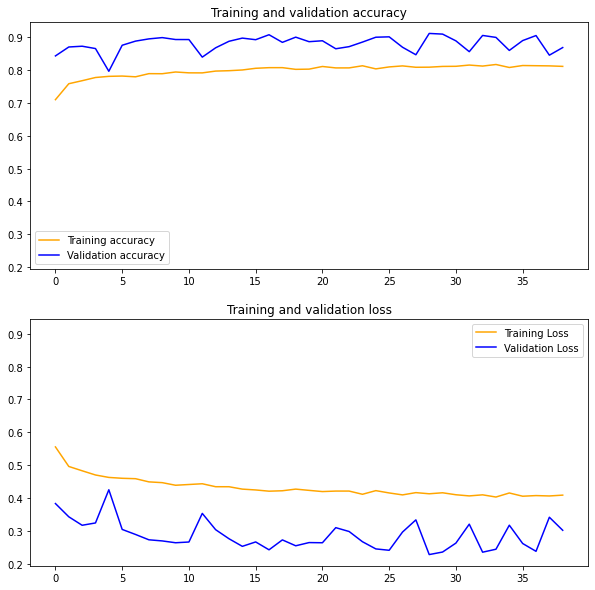

In [ ]:
acc = training_2.history['accuracy']
val_acc = training_2.history['val_accuracy']
loss = training_2.history['loss']
val_loss = training_2.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(10, 10))

ax[0].plot(epochs, acc, 'orange', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set(title='Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'orange', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set(title='Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
model_2.save("model_3.h5")